In [3]:
import xarray_beam as xb

ds, _ = xb.open_zarr('gcs://gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr')

In [4]:
print(ds.nbytes / (10**9))

41283.60431246


In [5]:
temp = ds['2m_temperature']

In [43]:
import numpy as np
import pandas as pd

lat_min, lat_max = (27, 42.0)
lon_min, lon_max = (120, 135)

lat_indices = np.where((ds.latitude >= lat_min) & (ds.latitude <= lat_max))[0]
lon_indices = np.where((ds.longitude >= lon_min) & (ds.longitude <= lon_max))[0]

source_dataset = temp.isel(latitude=lat_indices, longitude=lon_indices)

start_date = pd.to_datetime('2021-12-28')
end_date = pd.to_datetime('2021-12-29')
source_dataset = source_dataset.sel(time=slice(start_date, end_date))

print(source_dataset)



<xarray.DataArray '2m_temperature' (time: 5, latitude: 61, longitude: 61)>
[18605 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 42.0 41.75 41.5 41.25 ... 27.5 27.25 27.0
  * longitude  (longitude) float32 120.0 120.2 120.5 120.8 ... 134.5 134.8 135.0
  * time       (time) datetime64[ns] 2021-12-28 ... 2021-12-29
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K


In [44]:
dataset = source_dataset.values

In [45]:
print(dataset.shape)

(5, 61, 61)


(61, 61)


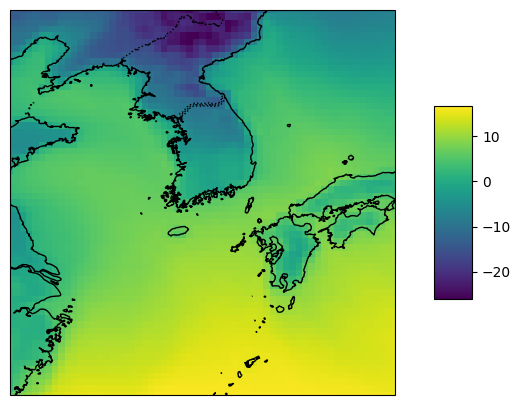

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 예제 NumPy 배열 생성
data = dataset[0][::-1, :]
print(data.shape)

data = data - 273.15

# 지도 생성 및 데이터 시각화
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 지도에 기본 레이어 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# NumPy 배열을 지도 위에 표시 (임의의 위경도 범위에 맞게 조정)
lons = np.linspace(lon_min, lon_max, data.shape[1])
lats = np.linspace(lat_min, lat_max, data.shape[0])
Lons, Lats = np.meshgrid(lons, lats)
mesh = ax.pcolormesh(Lons, Lats, data, transform=ccrs.PlateCarree())

plt.colorbar(mesh, ax=ax, shrink=0.5, aspect=5)

plt.show()

In [27]:
import torch

def get_tgt_mask(var_len, tgt_time_len) -> torch.tensor:
        matrix = torch.zeros(var_len * tgt_time_len, var_len * tgt_time_len)

        for i in range(tgt_time_len):
            for j in range(var_len):
                inf_idx = min(((i)*var_len), var_len * tgt_time_len)
                matrix[:(i*var_len), inf_idx:] = float('-inf')
        return matrix


print(get_tgt_mask(3, 5))

tensor([[0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,